<a href="https://colab.research.google.com/github/omridrori/generative-models/blob/main/VQGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch 
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import IPython.display as ipd

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.models import vgg16
from tqdm.notebook import tqdm

print("Downloading CLIP and installing requirements")
!git clone https://github.com/openai/CLIP                 &> /dev/null
!pip install -q  ftfy regex tqdm omegaconf pytorch-lightning &> /dev/null

from CLIP import clip # The clip model
from torchvision import transforms # Some useful image transforms
import torch.nn.functional as F # Some extra methods we might need
from tqdm.notebook import tqdm # A progress bar library

In [9]:
print('Downloading ImageNet 16384 checkpoints')
!curl -L 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' > vqgan_imagenet_f16_16384.yaml
!curl -L 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1' > vqgan_imagenet_f16_16384.ckpt

!cp 'drive/My Drive/vqgan_imagenet_f16_16384.yaml' vqgan_imagenet_f16_16384.yaml
!cp 'drive/My Drive/vqgan_imagenet_f16_16384.ckpt' vqgan_imagenet_f16_16384.ckpt

print('Installing a few libraries')
!git clone https://github.com/CompVis/taming-transformers &> /dev/null
!pip install einops                                       &> /dev/null
from omegaconf import OmegaConf
import sys
sys.path.append('./taming-transformers')
from taming.models import cond_transformer, vqgan

def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model

class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward
 
    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)
 
 
replace_grad = ReplaceGrad.apply
 
 
class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)
 
    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None
 
 
clamp_with_grad = ClampWithGrad.apply

def vector_quantize(x, codebook):
  d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
  indices = d.argmin(-1)
  x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
  return replace_grad(x_q, x)

def synth(z):
  z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
  return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

def rand_z(width, height):
  f = 2**(model.decoder.num_resolutions - 1)
  toksX, toksY = width // f, height // f
  n_toks = model.quantize.n_e
  one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()
  z = one_hot @ model.quantize.embedding.weight
  z = z.view([-1, toksY, toksX, model.quantize.e_dim]).permute(0, 3, 1, 2)
  return z

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   692  100   692    0     0    901      0 --:--:-- --:--:-- --:--:--   901
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  934M  100  934M    0     0  14.8M      0  0:01:02  0:01:02 --:--:-- 14.9M
cp: cannot stat 'drive/My Drive/vqgan_imagenet_f16_16384.yaml': No such file or directory
cp: cannot stat 'drive/My Drive/vqgan_imagenet_f16_16384.ckpt': No such file or directory
Installing a few libraries


In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = load_vqgan_model('vqgan_imagenet_f16_16384.yaml', 'vqgan_imagenet_f16_16384.ckpt').to(device)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

8.19kB [00:00, 269kB/s]                    


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_16384.ckpt


In [30]:
!curl --output cat.jpeg "https://images.pexels.com/photos/156934/pexels-photo-156934.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1" >> /dev/null
im = Image.open('/content/cat.jpeg').convert('RGB').resize((256, 256))
im = torch.tensor(np.array(im)).permute(2, 0, 1)/255
im = im.unsqueeze(0).to(device) * 2 - 1 # The encoder expects inputs in the range (-1, 1)
z, *_ = model.encode(im)
print('Image shape:', im.shape)
print('Z shape:', z.shape)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 58517  100 58517    0     0   227k      0 --:--:-- --:--:-- --:--:--  228k
Image shape: torch.Size([1, 3, 256, 256])
Z shape: torch.Size([1, 256, 16, 16])


In [31]:
out = synth(z)
out.shape

torch.Size([1, 3, 256, 256])

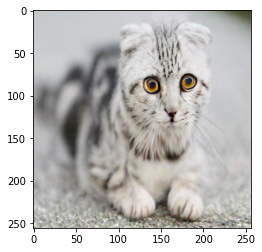

In [32]:
plt.imshow(out.detach().cpu().squeeze().permute(1, 2, 0))

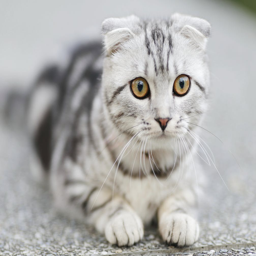

In [33]:
Image.open('/content/cat.jpeg').convert('RGB').resize((256, 256))

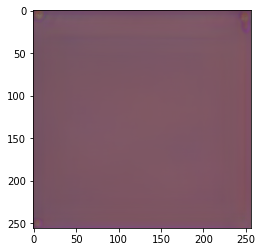

In [36]:
z = torch.rand(1, 256, 16, 16).to(device)
out = synth(z)
plt.imshow(out.detach().cpu().squeeze().permute(1, 2, 0))

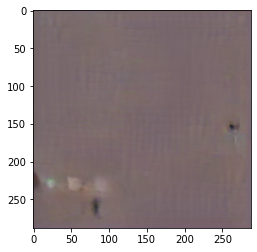

In [ ]:
im2 = Image.open('/content/deloitte-nl-cm-digital-human-promo (1).jpeg').convert('RGB').resize((256, 256))
im2 = torch.tensor(np.array(im2)).permute(2, 0, 1)/255
im2 = im2.unsqueeze(0).to(device) * 2 - 1 # The encoder expects inputs in the range (-1, 1)
z2, *_ = model.encode(im2)
print('Image shape:', im2.shape)
print('Z shape:', z2.shape)

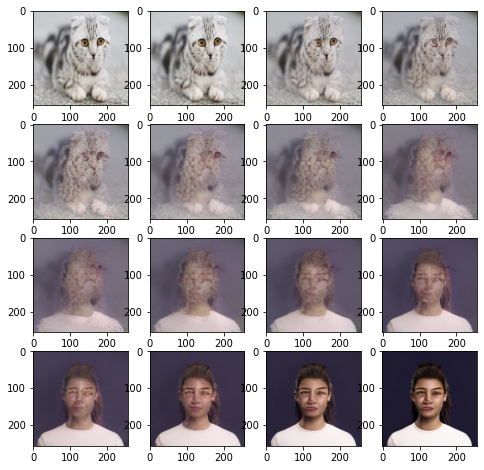

In [43]:
z1, *_ = model.encode(im) # The cat image from earlier
z2,*_ = model.encode(im2)
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i in range(16):
  z_new = z1 + (z2-z1)*(i/16)
  out = synth(z_new)
  axs[i//4, i%4].imshow(out.detach().cpu().squeeze().permute(1, 2, 0))